# CSC412/2506 Assignment 3: Variational Auto Encoders

In this assignment we will learn how to preform efficient inference and learning in directed graphical models with continuous latent variables.We will use stochastic variational inference with automatic differentiation (SADVI) to approximate intractible posterior distributions. We will implement the two gradient estimators discussed in lecture, Score Function and Reparamterization, and experimentally demonstrate their properties such as biasedness and variance. We will use the reparameterization gradient estimators to optimize the ELBO of our latent variable model.

You can use automatic differentiation in your code. You may also use a machine learning framework to specify the encoder and decoder neural networks, and provide gradientent optimizers such as ADAM. However, you may not use any probabilistic modelling elements for these frameworks. In particular, sampling from and evaluating densities under distributions must be written by you.

In [4]:
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.models import Sequential
import math
import torch
from torch import nn
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
torch.cuda.is_available()

True

## Implementing the VAE

In this assignment we will implement and investigate the Variational Auto Encoder on Binarized MNIST digits detailed in Auto-Encoding Bariational Bayes by Kingma and Welling (2013). Before starting, read this paper. In particular, we will implement model as described in Appendix C.

## Load and Prepare Data

Load the MNIST dataset, binarize the images, split into a training dataset of 10000 images and a test set of 10000 images. Also partition the training set into minibatches of size M=100.

In [582]:
# You may use the script provided in A2 or dataloaders provided by framework
mnist = tfk.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

#get 10000 images, and round the pixels
(x_train, y_train), (x_test, y_test) = (np.round(x_train[:10000, :, :]/225), y_train[:10000]), (np.round(x_test[:10000, :, :]/225), y_train[:10000])

#minibatches
x_train, y_train = np.split(x_train, 100), np.split(y_train, 100)
x_test, y_test = np.split(x_test, 100), np.split(y_test, 100)


## Distributions

Implement code to sample from and evaluate the log-pdf of diagonal multivariate gaussians  N(x|μ,σI)  and Bernoulli distributions. For sampling from these distributions, you have access to samples from uniform and unit Gaussians, (rand and randn). Make sure you test you've implemented these correctly by comparing to standard packages!

In [581]:
# sampler from Diagonal Gaussian x~N(μ,σI) (hint: use reparameterization trick here)
def GaussianSampler(dim, mu, cov):
    means = torch.ones((mu.shape[0], mu.shape[1]))*mu
    cov = torch.ones((cov.shape[0], cov.shape[1]))*cov
    eps = np.random.normal(loc = 0, scale = 1, size=(mu.shape[0], mu.shape[1]))
    eps = torch.from_numpy(eps).float()
    return (means.float() + eps*cov.float()).float()

# sampler from Bernoulli
def BernoulliSampler(dim, p):
    '''
    '''
    unif = np.random.uniform(low=0, high=1, size=(dim , 1))
    unif = np.where(unif <= p, unif, 1)
    unif = np.where(unif > p, unif, 0)
    return unif

# def BernoulliSampler2(dim, p):
    
# log-pdf of x under Diagonal Gaussian N(x|μ,σI)
def GaussianLogPDF(z, mu, cov, dim):
    z = z.float()
    mu = mu.float()
    cov = cov.float()
    diff = z-mu
    if diff.shape[1] != cov.shape[0]:
        cov = cov.transpose(0, 1)
    numer =  torch.mm((z-mu).float(), (1/cov).float())
    if numer.shape[1] != diff.shape[0]:
        diff = diff.transpose(0, 1)
    numer = -1/2 * torch.mm(numer, diff)
    denom = torch.log(torch.sqrt((2*math.pi)**dim * torch.prod(cov))).float()
    return numer - denom

# log-pdf of x under Bernoulli 
def BernoulliLogPDF(x, p):
    try:
        x =torch.from_numpy(x.reshape(100, 784))
    except (TypeError):
        x = x
    x, p = x.float(), p.float()
    if len(x.shape) == 3:
        x = x.reshape(100, 784)
    r = torch.sum(x*torch.log(0.000001 + p) + (1-x)*torch.log(0.000001 + 1 - p), dim=1)
    return r


## Defining Model Architecture

Implement the model as defined in Appendix C. The MLPs will have a single hidden layer with Dh=500 hidden units. The dimensionality of the latent space will be Dz=2 for visualization purposes later.

Note that the output of the encoder will be  [μ,logσ] . Why not ouput  σ  directly? Keep this in mind when you sample from the distribution using your Diagonal Gaussian sampler.

In [583]:
Dh, Dz = 500, 2

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
    
        self.enc1 = nn.Linear(28*28, Dh)
        self.mu = nn.Linear(Dh, Dz)
        self.logsig = nn.Linear(Dh, Dz)
    
        self.dec1 = nn.Linear(Dz, Dh)
        self.out = nn.Linear(Dh, 28*28)
    
    def encode(self, x):
        h1 = nn.functional.tanh(self.enc1(x))
        mu = self.mu(h1)
        sig = torch.exp(self.logsig(h1))
        return (mu, sig)
  
    def decode(self, z):
        h1 = nn.functional.tanh(self.dec1(z))
        return nn.functional.sigmoid(self.out(h1))
  
  
    def forward(self, x):
        x = x.reshape(100, 784)
        x = torch.from_numpy(x).float()
        mu, sig = self.encode(x)
        z = GaussianSampler(dim=784, mu=mu, cov=sig)
        recon = self.decode(z)
        return recon.float(), z.float(), mu.float(), sig.float()
    

## Variational Objective

Here we will use the log-pdfs, the encoder, gaussian sampler, and decoder to define the Monte Carlo estimator for the mean of the ELBO over the minibatch.

In [584]:
# log_q(z|x) logprobability of z under approximate posterior N(μ,σ)
def logprob_z_x(z, mu, sig):
    logprob = GaussianLogPDF(z, mu, sig, dim=2)
    return logprob
  
# log_p_z(z) log probability of z under prior
def logprob_z_z(z):
    logprob = GaussianLogPDF(z, mu=torch.tensor([[0, 0]]).expand(100, -1).float(), cov=torch.tensor([[1, 1]]).expand(100, -1).float(), dim=2)
    return logprob

# log_p(x|z) - conditional probability of data given latents.
def logprob_x_z(recon, p):
    logprob = BernoulliLogPDF(minibatch, recon)
    return logprob

# Monte Carlo Estimator of mean ELBO with Reparameterization over M minibatch samples.
# This is the average ELBO over the minibatch
# Unlike the paper, do not use the closed form KL between two gaussians,
# Following eq (2), use the above quantities to estimate ELBO as discussed in lecture
def loss_function(recon_x, x, mu, logvar):
    term1 = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784).float(), reduction='sum')
    
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return term1 + KL

## Optimizing with Gradient Descent

Minimize the -ELBO with ADAM optimizer. You may use the optimizer provided by your framework

In [589]:
autoencoder = VAE()
# Set up ADAM optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

# Train for ~200 epochs (1 epoch = all minibatches in traindata)
total_loss = 0
for t in range(200):
    for minibatch in x_train:
        optimizer.zero_grad()
        x_tildes, z, mu, sig = autoencoder(minibatch)
        minibatch = torch.from_numpy(minibatch)
        loss = loss_function(x_tildes, minibatch, mu, torch.log(sig))
        loss.backward()
        total_loss += loss.item()/100
        optimizer.step()
    
    
    print("Epoch " + str(t) + " has curr loss " + str(loss.item()/100) + " and total loss " +  str(total_loss))
    
    

Epoch 0 has curr loss 193.4658984375 and total loss 21806.319980468765
Epoch 1 has curr loss 186.705 and total loss 40367.469277343764
Epoch 2 has curr loss 183.25890625 and total loss 58462.34984375
Epoch 3 has curr loss 180.64396484375 and total loss 76320.55751953131
Epoch 4 has curr loss 178.6740625 and total loss 94015.6544042969
Epoch 5 has curr loss 176.73373046875 and total loss 111542.20834960946
Epoch 6 has curr loss 173.9803515625 and total loss 128877.4501171876
Epoch 7 has curr loss 171.34341796875 and total loss 146016.16623046892
Epoch 8 has curr loss 169.67130859375 and total loss 162980.8179394533
Epoch 9 has curr loss 168.123046875 and total loss 179786.2838183594
Epoch 10 has curr loss 166.1395703125 and total loss 196469.42199218742
Epoch 11 has curr loss 164.64541015625 and total loss 213042.09312499978
Epoch 12 has curr loss 163.45712890625 and total loss 229510.74815429645
Epoch 13 has curr loss 162.749970703125 and total loss 245876.70118164035
Epoch 14 has curr

Epoch 114 has curr loss 139.267998046875 and total loss 1748840.904824211
Epoch 115 has curr loss 138.586806640625 and total loss 1762964.5081054613
Epoch 116 has curr loss 138.3815234375 and total loss 1777086.843144524
Epoch 117 has curr loss 137.78546875 and total loss 1791209.4496386638
Epoch 118 has curr loss 137.3748828125 and total loss 1805341.6947753828
Epoch 119 has curr loss 138.087734375 and total loss 1819513.9862792883
Epoch 120 has curr loss 138.40451171875 and total loss 1833726.9277538983
Epoch 121 has curr loss 138.9307421875 and total loss 1847977.1159472573
Epoch 122 has curr loss 138.907216796875 and total loss 1862222.7458984288
Epoch 123 has curr loss 141.39638671875 and total loss 1876398.097890617
Epoch 124 has curr loss 140.188095703125 and total loss 1890495.5280761642
Epoch 125 has curr loss 138.677177734375 and total loss 1904568.3584179617
Epoch 126 has curr loss 139.39564453125 and total loss 1918615.431386713
Epoch 127 has curr loss 137.90505859375 and t

## Report ELBO on Training and Test Set

In [499]:
#ELBO on training set
train_elbo = 0
for batch in x_train:
    x_tildes, z, mu, sig = autoencoder(batch)    
    train_elbo += -loss_function(x_tildes, torch.from_numpy(batch), mu, torch.log(sig))/100
print(train_elbo)

#ELBO on test test:
test_elbo = 0
for batch in x_test:
    x_tildes, z, mu, sig = autoencoder(batch)
    test_elbo += -loss_function(x_tildes, torch.from_numpy(batch), mu, torch.log(sig))/100
    
print(test_elbo)

tensor(-13956.0078, grad_fn=<AddBackward0>)
tensor(-16189.5820, grad_fn=<AddBackward0>)


## Numerically Computing Intractable Integrals 

## Numerical Integration over Latent Space

Since we chose a low dimensional latent space, we are able to perform numerical integration to evaluate integrals which are intractible in higher dimension.

For instance, we will use this to integrate over the latent space. e.g. the
p(z|x)= p(x|z) ∗ p(z)p(x)= p(x|z) ∗ p(z) ∫p(x|z)*p(z)dz
 
We want to numerically compute that integral. However, since we are parameterizing  logp(x|z)  and  logp(z)  we will have
logp(z|x)= logp(x|z) + logp(z) − log ∫exp[ logp(x|z) + logp(z) ]dz
 
You will write code which computes  log∫explogf(z)dz  given an equally spaced grid of  logf(z) s as input. Note that if we approximate that integral with a numerical sum, in order for it to be numerically stable we will need logsumexp.

In [577]:

#Implement log sum exp
def my_logsumexp(x):
    m = np.max(x)
    n = x - m
    sumexp = np.exp(n).sum()
    return m + np.log(sumexp)

# Implement stable numerical integration 
# over a 2d grid of equally spaced (delta_z) evaluations logf(x)
def stable_numerical_integration(space, x, logf=logf, step=0.1):
    area = []
    i = 0
    for x_step in space:
        for y_step in space:
            z = torch.tensor([[x_step, y_step]])
            a = step*logf(x, z)
            area.append(a)
            i += 1
    return my_logsumexp(area)

# Data Space Visualizations

In [225]:
# Write a function to reshape 784 array into a 28x28 image for plotting
def pre_plot(x):
    return np.array(x.detach()).reshape((28, 28))

## Samples from the generative model

```
```



Here you will sample from the generative model using ancestral sampling.

First sample a z from the prior.
Then use the generative model to parameterize a bernoulli distribution over x given z. Plot this distribution.
Then sample x from the distribution. Plot this sample.
Do this for 10 samples z from the prior.

Concatenate all your plots into one 10x2 figure where the first column is the distribution over x and the second column is a sample from this distribution. Each row will be a new sample from the prior.

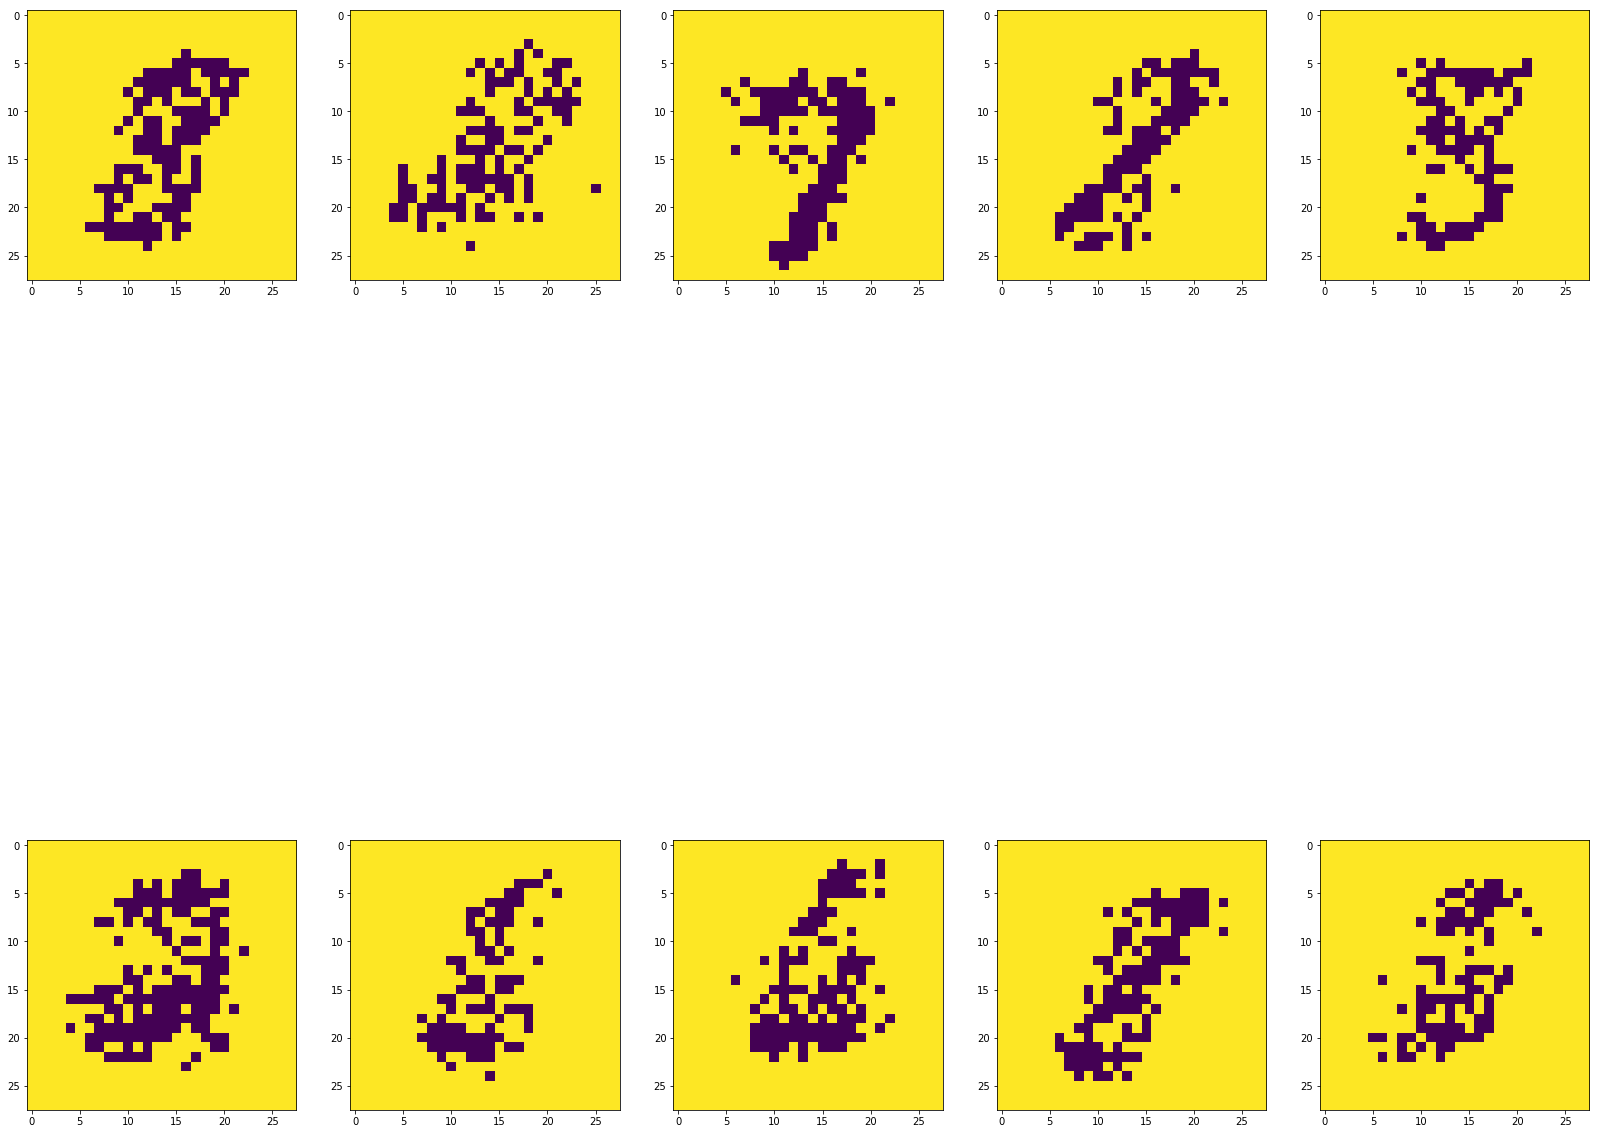

In [547]:
# Sample 10 z from prior
z = []
for j in range(10):
    z.append(GaussianSampler(dim=2, mu = torch.tensor([[0, 0]]).float(), cov = torch.tensor([[1, 1]]).float()))
  
# For each z, plot p(x|z)
recons = []
for sample in z:
    recons.append(pre_plot(autoencoder.decode(sample)))


bernoullids = []

# Sample x from p(x|z) 
for reconstruction in recons:
    bernoullids.append(BernoulliSampler(784, reconstruction.reshape((784, 1))))
  
  
# Concatenate plots into a figure
fig = plt.figure(figsize=(28, 28))
cols = 5
rows = 2

axes = []
for i in range(cols * rows):
    img = bernoullids[i].reshape((28, 28))
    axes.append(fig.add_subplot(rows, cols, i + 1))
    plt.imshow(img)

## Reconstructions of Data

Here we will investigate the VAEs ability to reconstruct 10 inputs from the data. For each input ou will


*   Plot the image x.
*   Use the recognition network to encode 𝑥 to the parameters for a distribution 𝑞(𝑧|𝑥).
*   Sample 𝑧∼𝑞(𝑧|𝑥)
*  Use the generative model to decode to the parameters for distribution 𝑝(𝑥|𝑧). Plot this
*  Sample 𝑥̃ ∼𝑝(𝑥|𝑧). Plot this



Then you will concatenate all your plots into a 10x3 figure where the first column is the input data, the second column is the distribution over x, the third column is a reconstruction of the input. Each row will be a new sample from the data.

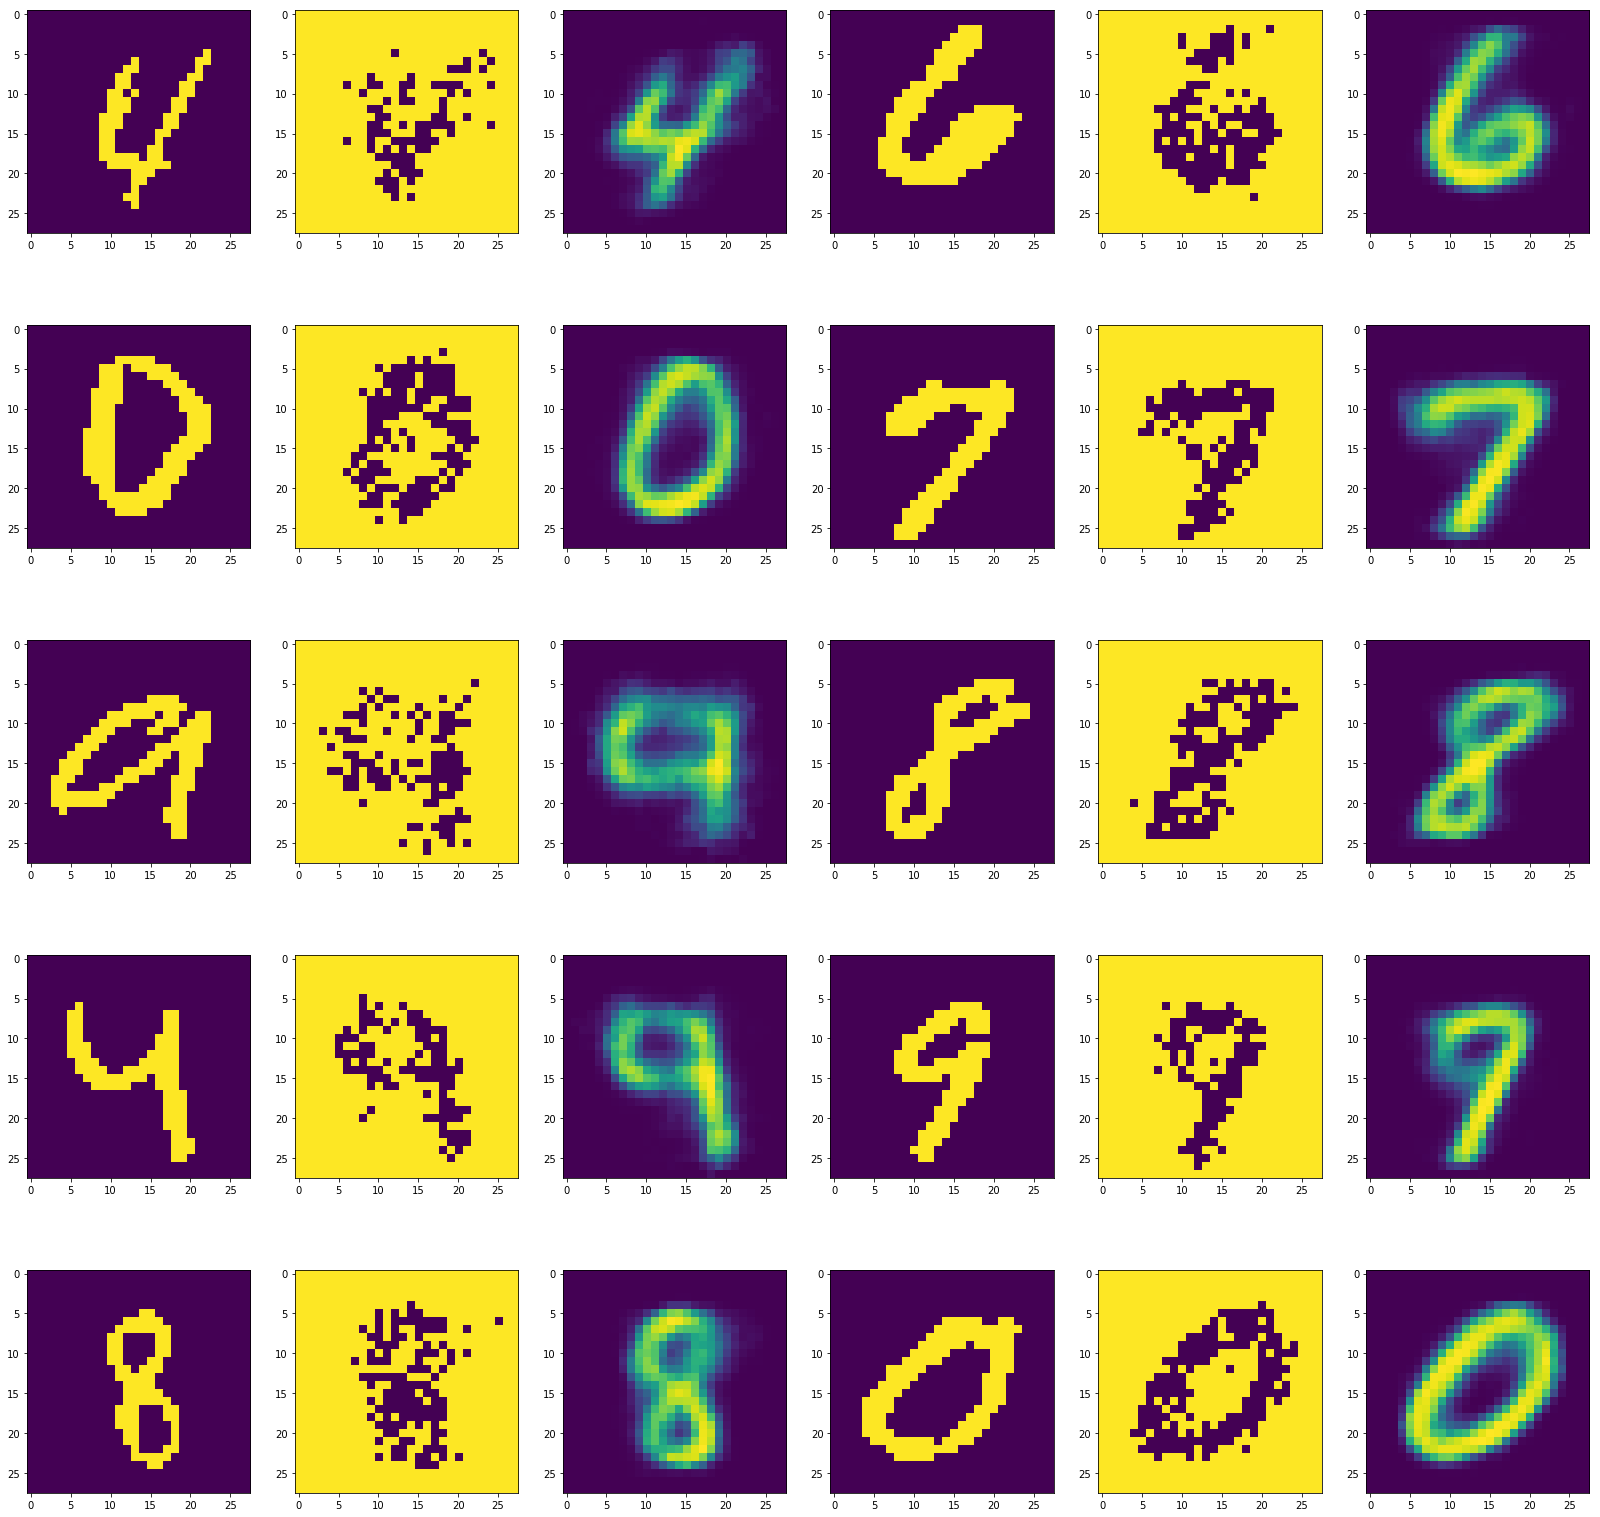

In [546]:
# Sample 10 xs from the data, plot.
data = []
num = np.round(np.random.uniform(low=0, high = 100, size=1))

data.append(x_train[int(num)][:][:, :])

# For each x, encode to distribution q(z|x)
variables = autoencoder.encode(torch.tensor(data[0]).view(100, 784).float())

i = 0
for var in variables:
    if i == 0:
        mu = var[:10, :]
    else:
        cov = var[:10, :]
    i += 1


# For each x, sample distribution z ~ q(z|x)
latents = []

for j in range(10):
    mu_i = mu[j,:].view(mu[j,:].shape[0], 1)
    cov_i = cov[j,:].view(cov[j,:].shape[0], 1)
    latents.append(torch.transpose(GaussianSampler(dim=2, mu=mu_i, cov=cov_i), 0, 1))

decoded = []
# For each z, decode to distribution p(x̃|z), plot.
for z in latents:
    decoded.append(autoencoder.decode(z))

  

# For each x, sample from the distribution x̃ ~ p(x̃|z), plot.
sampled = []
for dec in decoded:
    sampled.append(BernoulliSampler(784, np.array(dec.detach()).reshape((784, 1))))

# Concatenate all plots into a figure.

fig_final = plt.figure(figsize=(28, 28))
cols_final = 6
rows_final = 5

axes_decoded = []
i = 0
for t in range(cols_final * rows_final):
    if t == 0:
        img = data[0][0][:, :]
    elif t % 3 == 0:
        img = data[0][i].reshape((28, 28))
    elif t % 3 == 1:
        img = sampled[i].reshape((28, 28))
    else:
        img = decoded[i].detach().reshape((28, 28))
        i += 1
    axes.append(fig_final.add_subplot(rows_final, cols_final, t + 1))
    plt.imshow(img)


# Latent Space Visualizations

In this section we will investigate our model by visualizing the latent space through various methods. These will include encoding the data, decoding along a grid, and linearly interpolating between encdoded data.

## Latent Embedding of Data

One way to understand what is represented in the latent space is to consider where it encodes elements of the data. Here we will produce a scatter plot in the latent space, where each point in the plot will be the mean vector for the distribution  q(z|x)  given by the encoder. Further, we will colour each point in the plot by the class label for the input data.

Hopefully our latent space will have learned to distinguish between elements from different classes, even though we never provided class labels to the model!

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


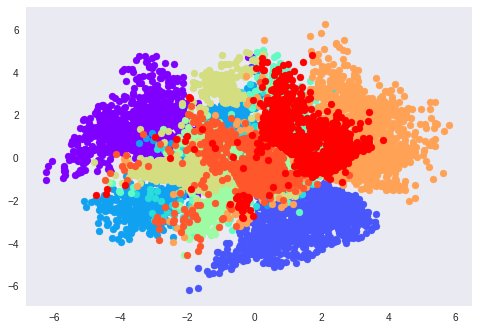

In [0]:
# Encode the training data
all_encoded = []
for i in range(len(x_train)):
    all_encoded.append((autoencoder.encode(torch.from_numpy(x_train[i].reshape((100, 784))).float())))

# Take the mean vector of each encoding
means = []
for t in range(len(all_encoded)):
    means.extend(np.concatenate((all_encoded[t][0].detach(), y_train[t].reshape((100, 1))), axis=1))

means = np.stack(means, axis=0)
sortedByClass = np.matrix(sorted(means, key=lambda row:row[-1]))

cmap = cm.rainbow(np.linspace(0.0, 1.0, 10))

prev, fin=0, []
for i in range(10):
    lastIndex = np.where(sortedByClass[:, -1] == i)[0][-1] + 1
    oneClass = sortedByClass[prev:lastIndex, :][:]
    fin.append(oneClass)
    prev=lastIndex
    plt.scatter(list(oneClass[:, 0]), list(oneClass[:, 1]), color = cmap[i])
plt.grid()
   


# Colour each point depending on the class label

## Decoding along a lattice

We can also understand the "learned manifold" by plotting the generative distribution  p(x|z)  for each point along a grid in the latent space. We will replicate figure 4b in the paper.

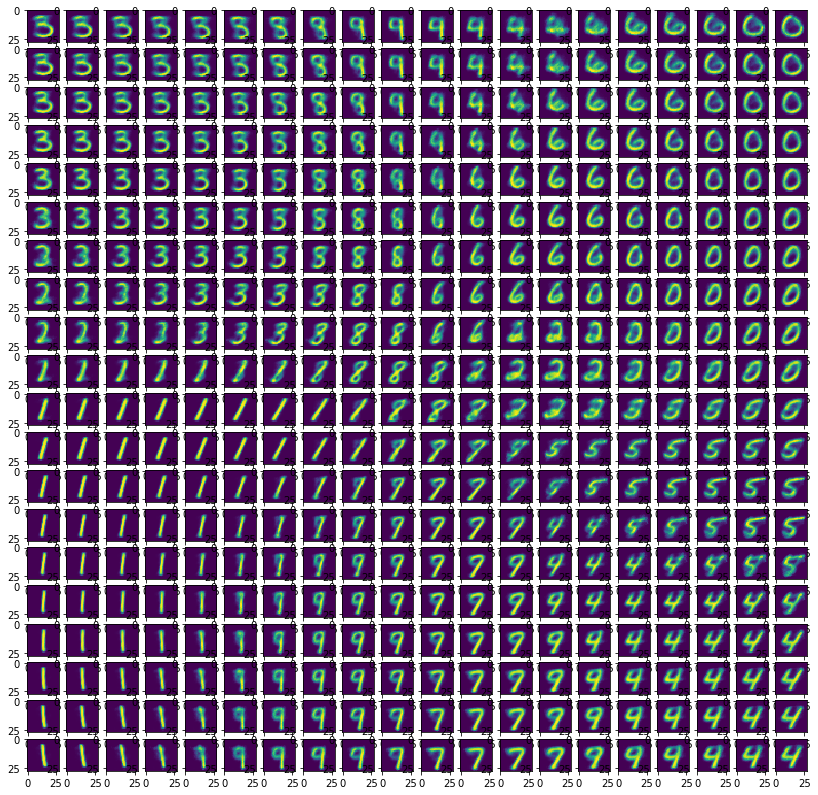

In [244]:
# Create a 20x20 equally spaced grid of z's
# (use the  previous figure to help you decide appropriate bounds for the grid)
x = np.linspace(-3, 3, 20)
y = np.linspace(-3, 3, 20)

# For each z on the grid plot the generative distribution over x
x_fig = plt.figure(figsize=(14, 14))
x_cols = 20
y_cols = 20

x_axes = []
h = 0
for dx in x:
  for dy in y:
    img = autoencoder.decode(torch.tensor([[dx, dy]])).detach().reshape((28, 28))
    x_axes.append(x_fig.add_subplot(x_cols, y_cols, h+1))
    h += 1
    plt.imshow(img)
    
    

# concatenate these plots to a lattice of distributions

## Interpolate between two classes

A common technique to assess latent representations is to interpolate between two points.

Here we will encode 3 pairs of data points with different classes. Then we will linearly interpolate between the mean vectors of their encodings. We will plot the generative distributions along the linear interpolation.

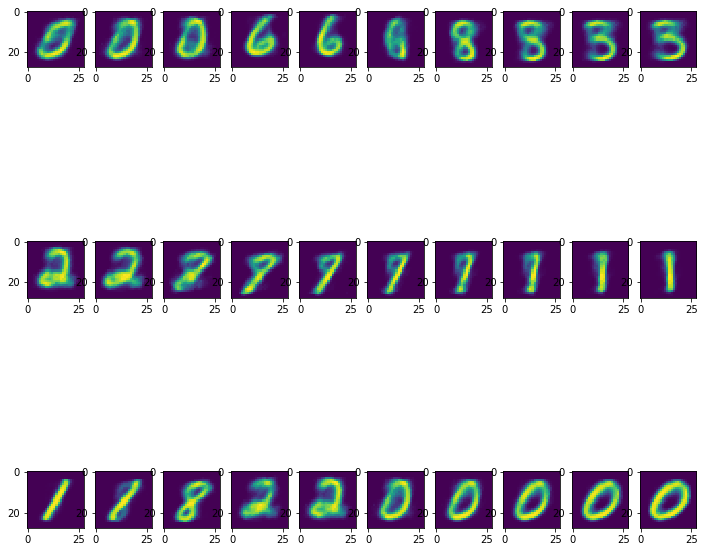

In [543]:
# Function which gives linear interpolation z_α between za and zb
def linear_interpolation(za, zb, t):
    return t*za + (1-t)*zb

# Sample 3 pairs of data with different classes
pts = []
minibatch = x_train[7]
for t in range(3):
    rand1 = int(np.round(np.random.uniform(0, 99, 1)))
    rand2 = int(np.round(np.random.uniform(0, 99, 1)))
    x1 = minibatch[rand1][:, :]
    x2 = minibatch[rand2][:, :]
    c1, c2 = y_train[0][rand1], y_train[0][rand2]
    while c1 == c2:
        rand2 = int(np.round(np.random.uniform(0, 100, 1)))
        c2 = y_train[0][rand2]
        x2 = minibatch[rand2][:, :]
    
    pts.append((x1, x2))

# Encode the data in each pair, and take the mean vectors
for i in range(len(pts)):
    pts[i] = (autoencoder.encode(torch.from_numpy(pts[i][0].reshape((1, 784))).float())[0], autoencoder.encode(torch.from_numpy(pts[i][1].reshape((1, 784))).float())[0])

# Linearly interpolate between these mean vectors
steps = np.linspace(0, 1, 10)
all_paths = []


for pair in pts:
    path = []
    for step in steps:
        path.append(autoencoder.decode(linear_interpolation(pair[0], pair[1], step)))
    
    all_paths.append(path)

# Along the interpolation, plot the distributions p(x|z_α)


# Concatenate these plots into one figure
path_fig = plt.figure(figsize=(12, 12))
columns = 3 
rows = 10

path_axes = []
t = 0
for path in all_paths:
    for step in path:
        img = step.detach().numpy().reshape((28, 28))
        path_axes.append(path_fig.add_subplot(columns, rows, t+1))
        t += 1
        plt.imshow(img)


    